In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from datetime import datetime

import torch
from torch.utils.data import DataLoader
from torchmetrics import MeanSquaredError

from dlwpt import ROOT
from dlwpt.basic_autoencoder import AutoEncoder, AutoEncoderDataset
from dlwpt.trainer import Trainer
from dlwpt.utils import set_device, get_mnist_datasets
from dlwpt.plots import plot_loss, plot_projections, get_projections, plot_images

In [3]:
NOW = datetime.now().strftime('%Y%m%d-%H%M')
LOG_DIR = ROOT.joinpath('runs', NOW)
BATCH = 128

device = set_device()

In [4]:
train, test = get_mnist_datasets(do_augment=False)
train_ds, test_ds = AutoEncoderDataset(train), AutoEncoderDataset(test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH)
eval_loader = DataLoader(test, batch_size=10)

In [5]:
mod = AutoEncoder(layers=(128, 64, 16), input_shape=(28, 28))
opt = torch.optim.AdamW(mod.parameters(), lr=0.001)
trainer = Trainer(
    mod, epochs=25, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model-1.pt'),
    optimizer=opt, score_funcs={'mse': MeanSquaredError()}
)
trainer.fit(train_loader, test_loader)

Batch:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 466/469 [00:07<00:00, 69.40it/s]
                                                                                                                                                                                                    
Batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 467/469 [00:07<00:00, 59.99it/s]
                                                                                                                                                                                                    
Batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 468/469 [00:07<00:00, 64.23it/s]
               

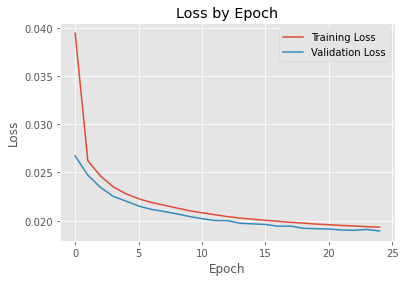

In [6]:
plot_loss(trainer.results)

<hr>

In [8]:
batch = next(iter(eval_loader))

In [9]:
images = []
mod.eval()
with torch.no_grad():
    for i, x in enumerate(batch[0]):
        images.append((x.squeeze(), mod.predict(x.unsqueeze(0).to(torch.float32).to(device)).squeeze()))

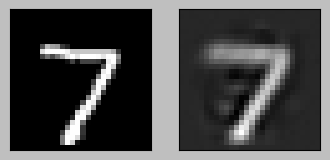

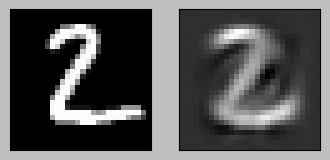

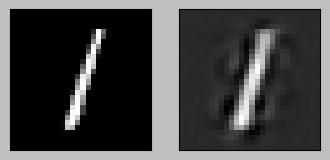

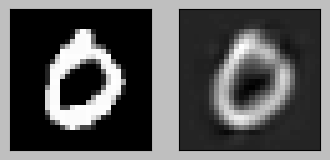

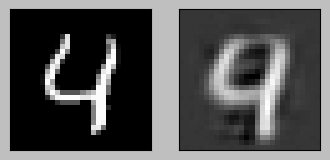

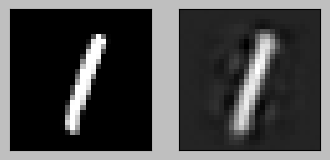

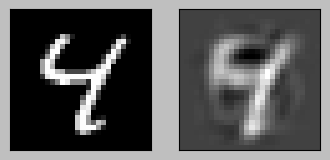

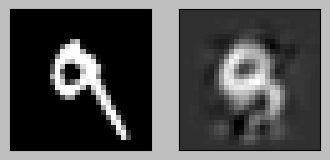

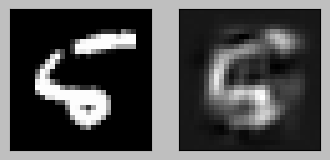

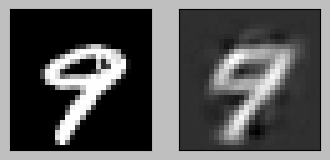

In [10]:
for img in images:
    plot_images(img[0], img[1].cpu())

<hr>

In [11]:
mod = AutoEncoder(layers=(256, 64, 16, 2), input_shape=(28, 28))
opt = torch.optim.AdamW(mod.parameters(), lr=0.001)
trainer = Trainer(
    mod, epochs=25, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model-2.pt'),
    optimizer=opt, score_funcs={'mse': MeanSquaredError()}
)
trainer.fit(train_loader, test_loader)

Batch:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 466/469 [00:09<00:00, 53.31it/s]
                                                                                                                                                                                                    
Batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 468/469 [00:08<00:00, 53.81it/s]
                                                                                                                                                                                                    
Batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 468/469 [00:08<00:00, 54.07it/s]
               

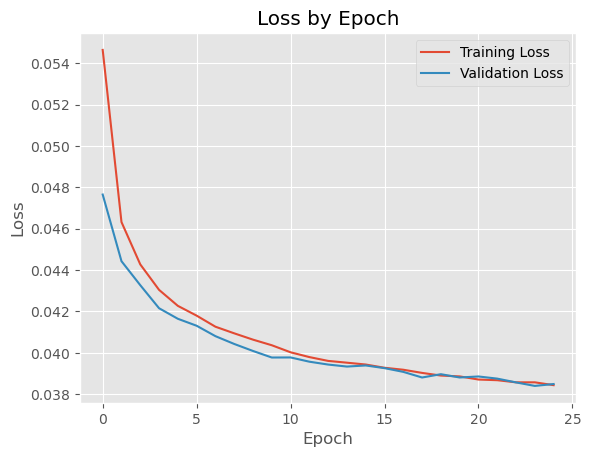

In [12]:
plot_loss(trainer.results)

In [13]:
eval_loader = DataLoader(test, batch_size=BATCH)

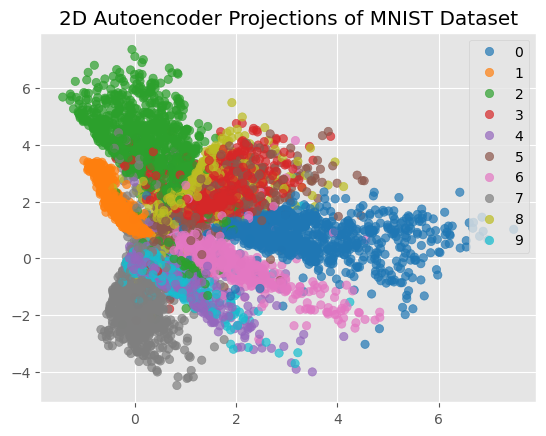

In [19]:
plot_projections(*get_projections(mod, eval_loader))